In [1]:
# You only need to run this once per run
# This allows running the Python files
import sys; sys.path.insert(0, '..')

In [2]:
## Import from my files
from lib.data_lfp import mne_lfp_Axona, load_lfp_Axona
from lib.data_pos import RecPos
from lib.plots import plot_small_sq, plot_tmaze, plot_mne

In [3]:
%matplotlib inline
import os
import re
from mne.preprocessing import ICA
import mne
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import statistics
import math
import random
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.cm as cm
from shapely.geometry import Point, Polygon
from matplotlib.collections import LineCollection
from matplotlib.ticker import MultipleLocator

In [22]:
# Set up file paths
base_directory = "D:\SubRet_recordings_imaging"
data_scheme_path = os.path.join(base_directory, "data_scheme.csv")

### **Read data table and select Tmaze recordings**


In [23]:
df = pd.read_csv(data_scheme_path, parse_dates=['date_time'] )
df = df.loc[df.maze != 'screening']
df = df.loc[df.habituation == 0]
tmaze_files = df.loc[df.maze == 'tmaze', ['folder', 'filename']].agg('/'.join, axis=1).values
df.head()

,filename,folder,duration,rat,n_channels,sleep,maze,habituation,treatment,light,date_time
0,02102018_C64_CSubSubRet1_smallsq_screen_1_1.set,D:/SubRet_recordings_imaging/C64_CSubSubRet1/s...,901.0,CSubSubRet1,32,0,small_sq,0,Control,NaN,2018-10-02 10:58:00
1,04102018_C64_CSubSubRet1_smallsq_screen_2_1.set,D:/SubRet_recordings_imaging/C64_CSubSubRet1/s...,120.0,CSubSubRet1,32,0,small_sq,0,Control,NaN,2018-10-04 12:12:01
2,25022019_CanCCaRet1_smallsq_1_1.set,D:/SubRet_recordings_imaging/CanCCaRet1/smalls...,387.0,CanCCaRet1,32,0,small_sq,0,Control,NaN,2019-02-25 15:51:03
3,26022019_CanCCaRet1_smallsq_2_1.set,D:/SubRet_recordings_imaging/CanCCaRet1/smalls...,499.0,CanCCaRet1,32,0,small_sq,0,Control,NaN,2019-02-26 17:51:00
4,04032019_CanCCaRet1_smallsq_1_1.set,D:/SubRet_recordings_imaging/CanCCaRet1/smalls...,120.0,CanCCaRet1,32,0,small_sq,0,Control,NaN,2019-03-04 17:25:00


In [6]:
# Convert the file to use
def select_file_from_list(list_, file):
    if isinstance(file, int):
        file = list_[i]
    return file

In [11]:
# Select the file to use
file_to_use = random.randint(0,len(tmaze_files))
fpath = r"CSR6/+ maze/27032018_t3/S8/27032018_CSR6_+maze_t3_.set"
file_to_use = os.path.join(base_directory, os.path.normpath(fpath))
file = select_file_from_list(tmaze_files, file_to_use)

if not os.path.isfile(file_to_use):
    print(f"{file_to_use} is not a valid path")
else:
    print(f"{file_to_use} is selected")

D:\SubRet_recordings_imaging\CSR6\+ maze\27032018_t3\S8\27032018_CSR6_+maze_t3_.set is selected


### **Open LFP data in MNE**

Creating RawArray with float64 data, n_channels=32, n_times=14750
    Range : 0 ... 14749 =      0.000 ...    58.996 secs
Ready.


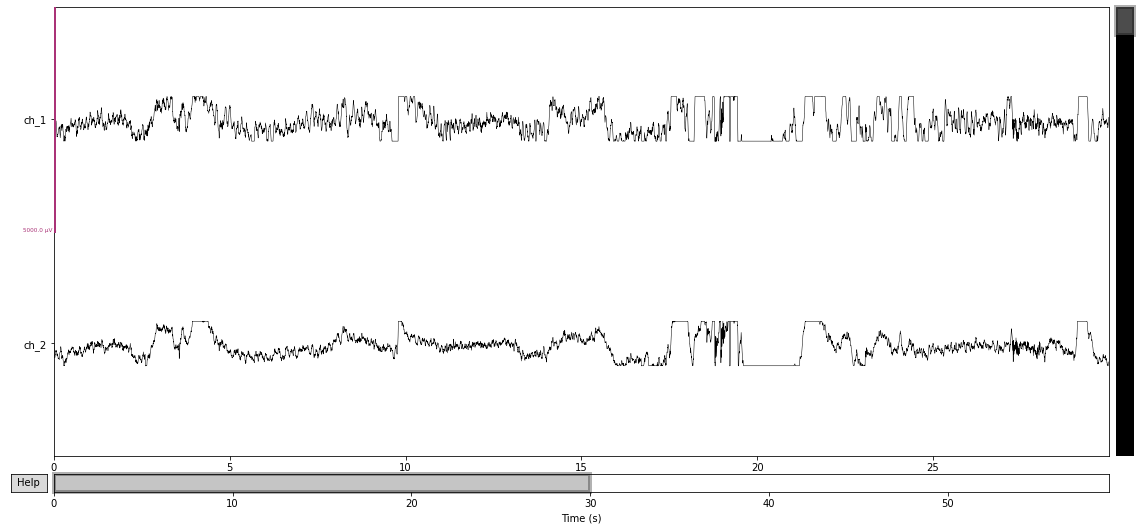

In [12]:
lfps = mne_lfp_Axona(file)
pos = RecPos(file)
plot_mne(lfps, file)

### From the start, for each position sample (50hz), 5 EEGs samples are collected. 
**Cut all nan values from the x,y and keep the smaller continuous (x or y) trunked by nans**

In [ ]:
# for file in tmaze_files:
#     try:
#         pos = RecPos(file)
#         x,y = pos.get_position()
#         rx,ry = pos.get_raw_pos()
#         nanX =  sum([a for a in x if a == np.nan])
#         nanY = sum([a for a in y if a == np.nan])
#         if nanX >0:
#             print(f' x: {nanX}\t y: {nanY}')
#     except:
#          continue

### **Finding decision region**

**TODO:**

1. get the order of the points

2. find where the animal turned to left or right



**Find the turn:**
   1. define a vector lenght (ex. 100)
   2. walk with this vector from the middle of the start arm to the end
   3. divide this vector into 2 with a gap in the middle (ex. a: 40 gap:20 b:40)
   4. Normalize both small vectors
   5. calculate the direction with dot product
    

#### **Helper functions**

In [13]:
coord = {
    'down left': [(225,110),(290,175),(180,235),(100, 140)],
    'top left':  [(100,250),(205,390),(300,340),(180,200)],
    'top right':[(370,235),(260,310),(360, 400),(460,330)],
    'down right':  [(365,100),(465,160),(375,230),(290,160)],
    'impossible to find': [(0,1),(2,1),(2, 2),(2,2)]
     }

def is_inside(x, y, start):
    points_inside = []
    coord = {
        'down left': [(225,110),(290,175),(180,235),(100, 140)],
        'top left':  [(100,250),(205,390),(300,340),(180,200)],
        'top right':[(370,235),(260,310),(360, 400),(460,330)],
        'down right':  [(365,100),(465,160),(375,230),(290,160)],
        'impossible to find': [(0,1),(2,1),(2, 2),(2,2)]
     }
    region = Polygon(coord[start])
    for vx,vy in zip(x,y):
        p = Point(vx,vy)
        if p.within(region):
            points_inside.append((vx,vy))
    if len(points_inside) > 0:
        return points_inside
    else: 
        return False

def move_window(x, y, idx, size, space):
    '''break the vextor into 2 divided by a space in the middle'''
    bx = x[idx : idx + size]
    by = y[idx : idx + size]
    cx = x[idx + size + space : idx + 2*size + space]
    cy = y[idx + size + space : idx + 2*size + space]
    return bx, by, cx, xy

def calculate_regression(x, y):
    '''Calculate linear regression and return the new line'''
    regr = linear_model.LinearRegression()
    x = np.array(x).reshape(-1,1)    
    y = np.array(y)
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred
 
def calculate_angle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def calculate_lenght(a, b):
    return math.sqrt(((a[-1] - a[0])**2) + ((b[-1] - b[0])**2))


def is_out(x_med, y_med, px, py, d):
    ''' Cheks if a point is far from the (x_mean, y_mean) point
    Given a point (px,py) and the mean of start, the function
    return True of False if the point is outside a defined 
    distance
    
    input: (float): x_mean, y_mean, px, py
    output: (bool):
    '''
    return  d > math.sqrt((px-x_med)**2 + (py-y_med)**2)
        
    
def get_cord_inside(x,y,start):
    '''check if points are inside the determined 
    region based on start'''
    
    insiders = is_inside(x,y,start)
    area = coord[start]
    aera_x = [b[0] for b in area]
    area_y = [b[1] for b in area]
    if pos.get_tmaze_start() in coord.keys():
        c = coord[pos.get_tmaze_start()]
    px = [b[0] for b in insiders]
    py = [b[1] for b in insiders]
    return px,py


# def filter_high_density_point(x,y):
    
#     read = {}
#     points = [(xn,yn) for xn,yn in zip(x,y)]
#     count_dict = {i:points.count(i) for i in points}
#     for k in count_dict.keys():
#         if count_dict[k]
    
#     return x,y

In [20]:
pos = RecPos(file)
x,y = pos.get_position()
start = pos.get_tmaze_start()
wview = pos.get_window_view()
print(wview)

{'window_min_x': 173, 'window_max_x': 670, 'window_min_y': 22, 'window_max_y': 505}


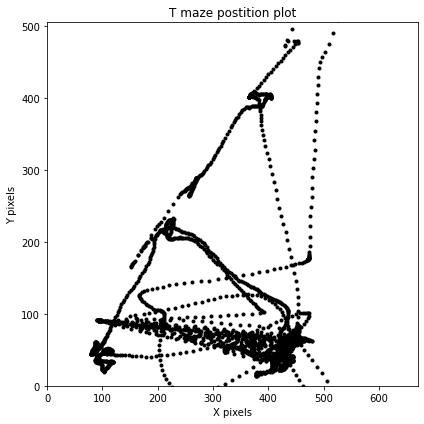

In [19]:
plot_tmaze(x, y, wview, dot=True)

#### **Test Sean idea of getting values outside a range from the beggining**

In [ ]:
def find_start_points(file):
    pos = RecPos(file)
    x,y = pos.get_position()
    start = pos.get_tmaze_start()
    wview = pos.get_window_view()
    #remove nans
    x = np.asarray(x)[~np.isnan(x)]
    y = np.asarray(y)[~np.isnan(y)]
    ax = plt.figure(figsize=(6,6))
    ax = plt.plot(x,y, c='black', linewidth=.4)
    x_med = np.median(x[300:500])
    y_med = np.median(y[300:500])
    outs = 0
    st = 200
    idx = st
    outx = []
    outy= []
    d = 90
    for px, py in list(zip(x,y))[st:]:
        idx+=1
        if math.sqrt((px-x_med)**2 + (py-y_med)**2) >= d:
            outs+=1
            outx.append(px)
            outy.append(py)
            if outs > 30:
                break
        else:
            outs = 0
            outx = []
            outy= [] 
    return idx

587


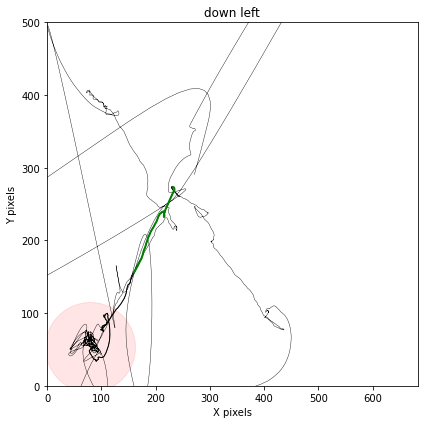

634


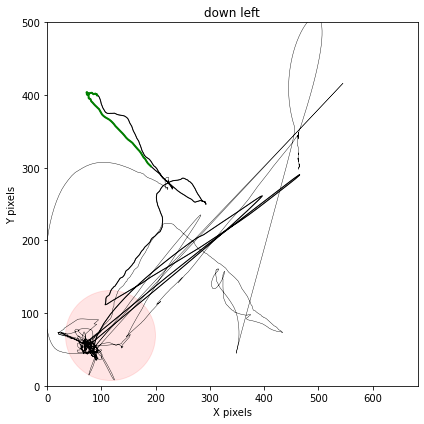

755


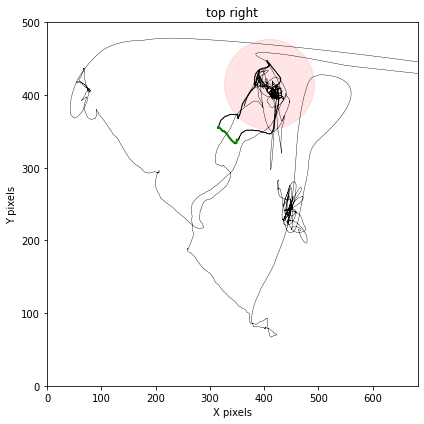

1701


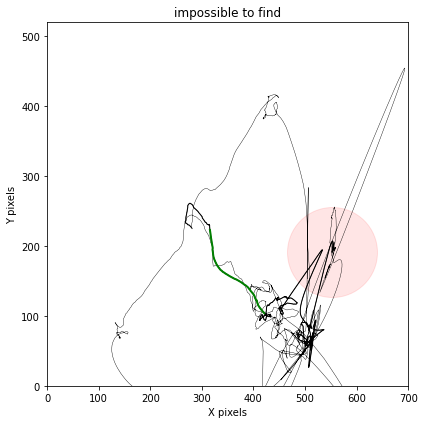

730


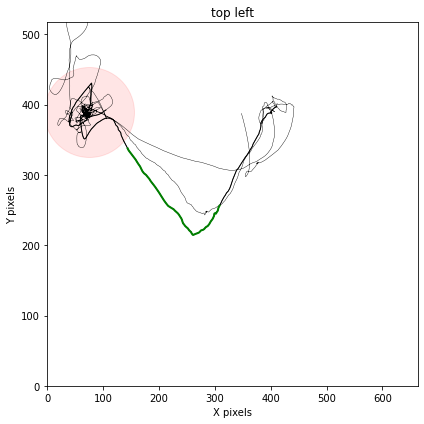

782


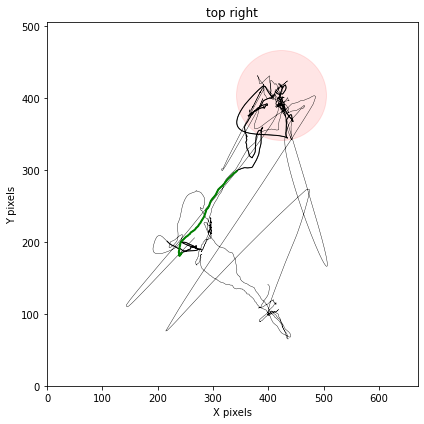

291


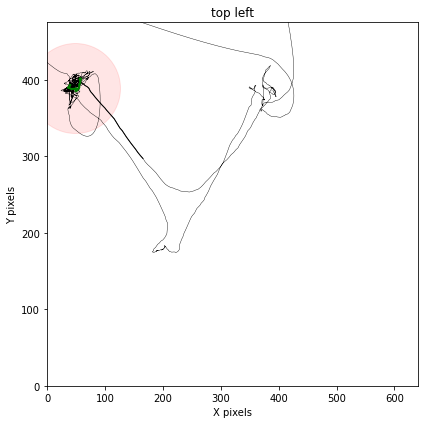

604


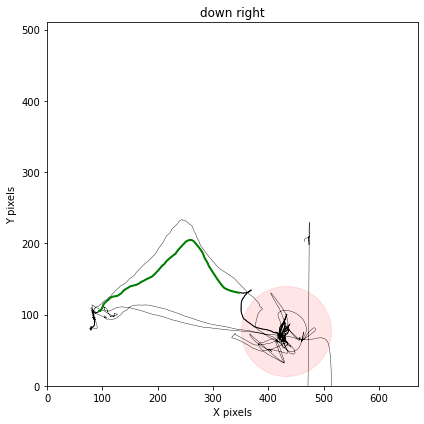

825


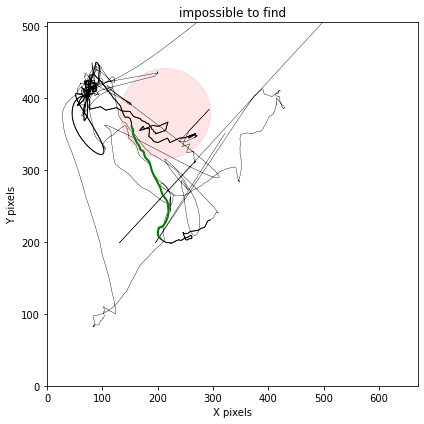

769


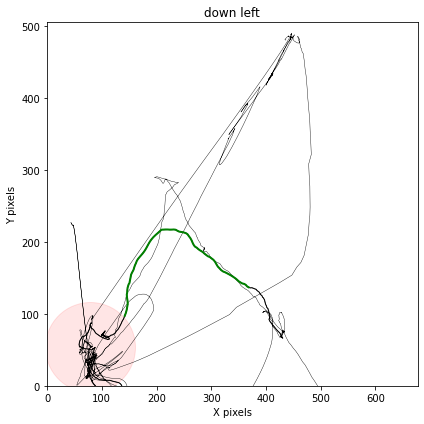

662


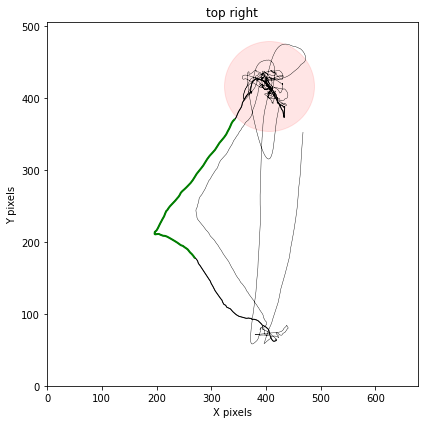

782


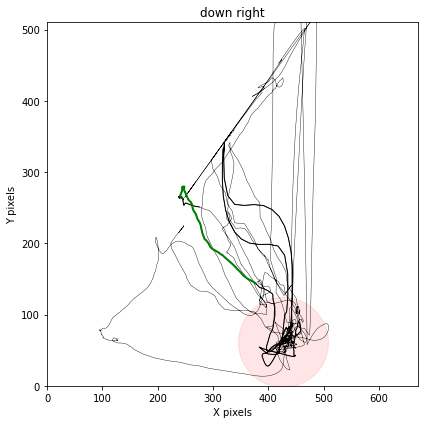

291


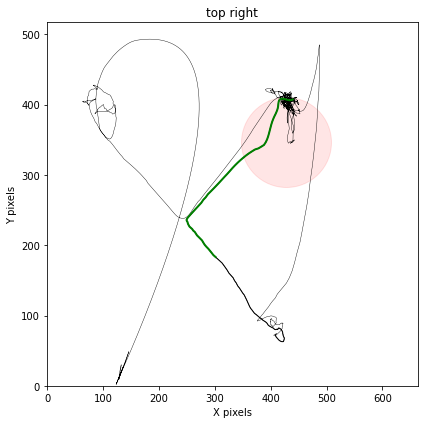

953


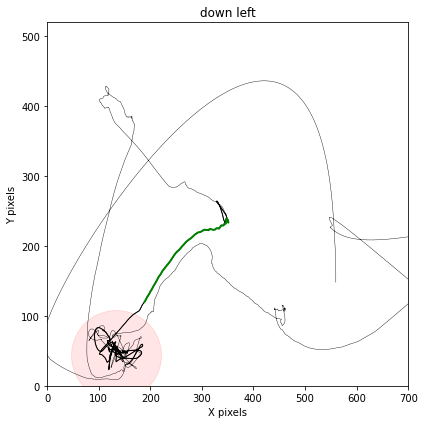

658


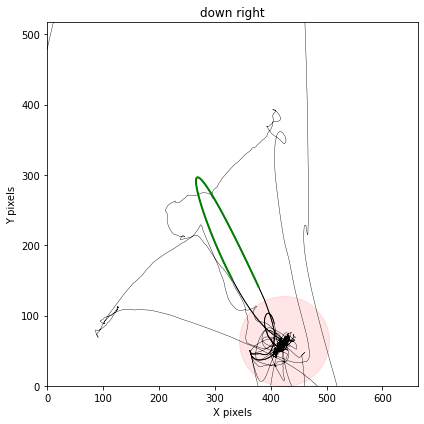

1072


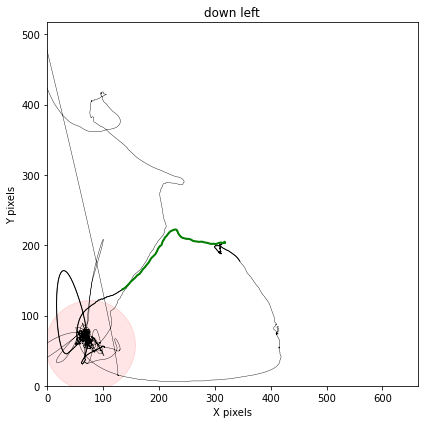

752


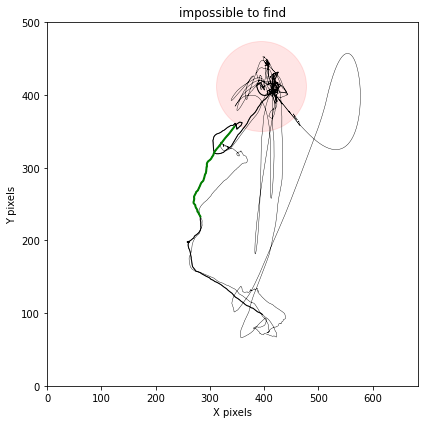

852


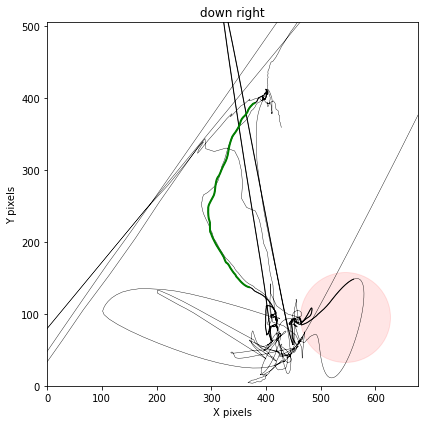

579


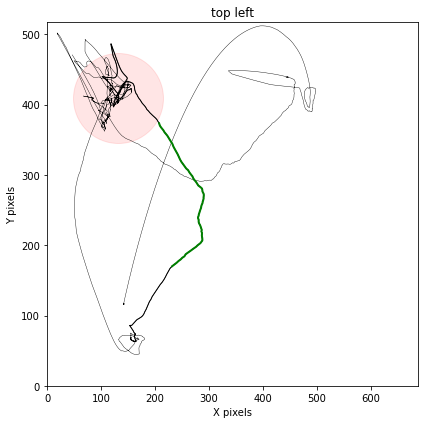

543


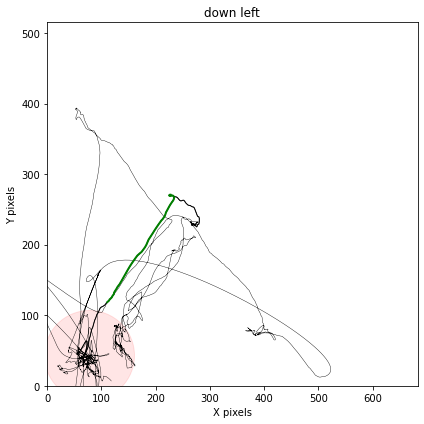

602


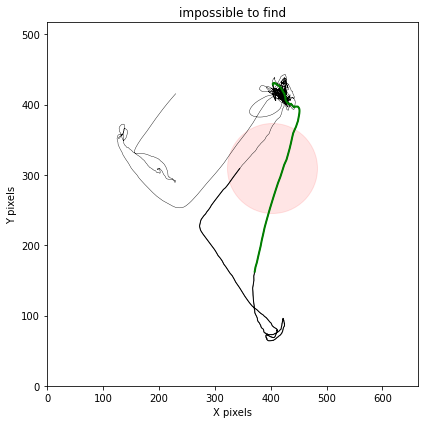

692


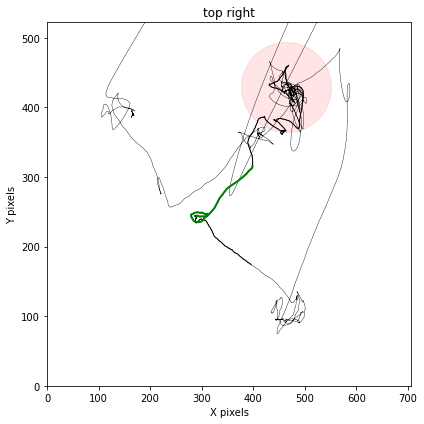

795


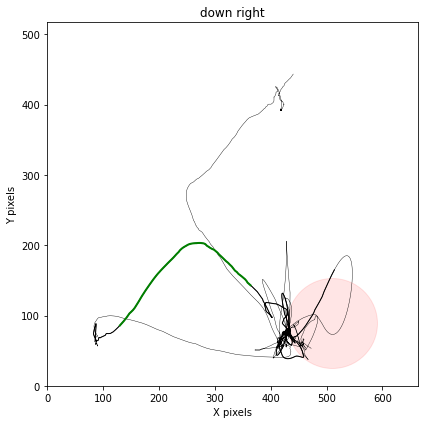

1044


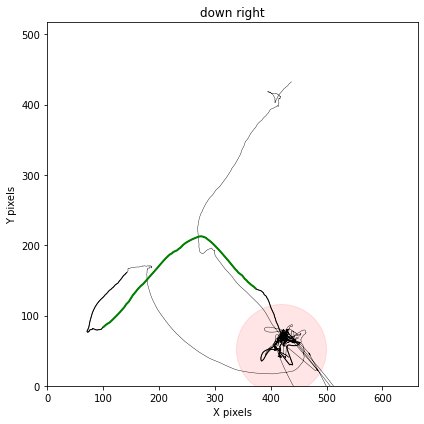

1328


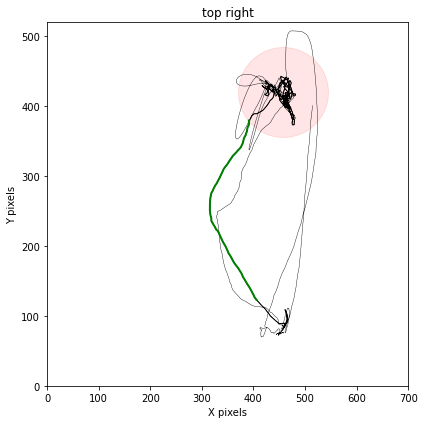

938


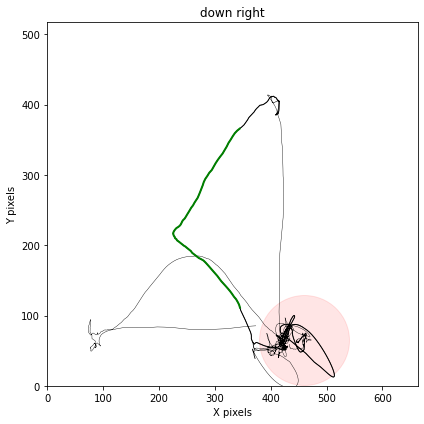

635


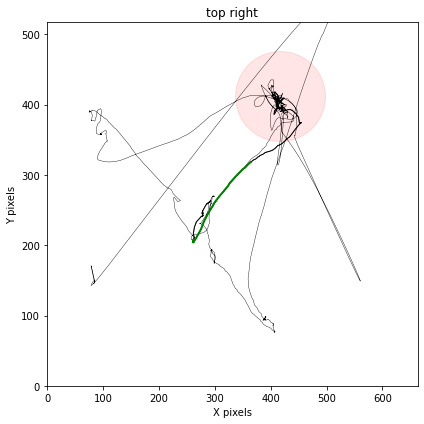

632


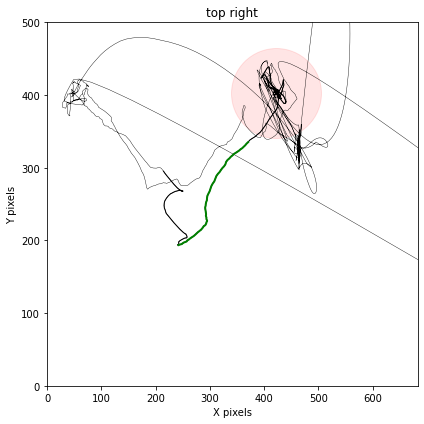

291


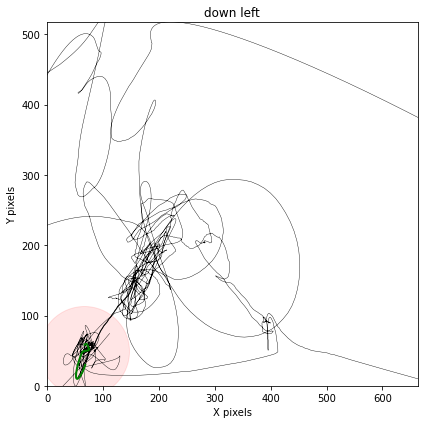

784


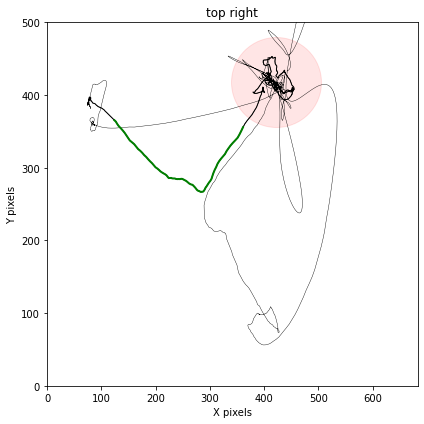

In [24]:
for i in range(0, 30):
    i = random.randint(0,len(tmaze_files))
    file = tmaze_files[i]
    pos = RecPos(file)
    x,y = pos.get_position()
    start = pos.get_tmaze_start()
    wview = pos.get_window_view()
    #remove nans
    x = np.asarray(x)[~np.isnan(x)]
    y = np.asarray(y)[~np.isnan(y)]
    ax = plt.figure(figsize=(6,6))
    ax = plt.plot(x,y, c='black', linewidth=.4)
    x_med = np.median(x[300:500])
    y_med = np.median(y[300:500])
    st = 200
    idx = st
    outx = []
    outy= []
    d = 90
    for px, py in list(zip(x,y))[st:]:
        idx+=1
        if math.sqrt((px-x_med)**2 + (py-y_med)**2) >= d:
            outx.append(px)
            outy.append(py)
            if len(outx) > 90:
                break
        else:
            outs = 0
            outx = []
            outy= [] 
            
    x_med = np.median(x[100:300])
    y_med = np.median(y[100:300])
    x = x[st:idx+100]
    y = y[st:idx+100]
    ax = plt.plot(x,y, c='black', linewidth=1)
    ax = plt.plot(outx,outy, c='green', linewidth=2)
    ax = plt.xlim(0, xmax=int(wview['window_max_x']))
    ax = plt.ylim(0, ymax=int(wview['window_max_y']))
    ax = plt.scatter(x_med, y_med , c="red",s = d**2, alpha =.1)
    ax = plt.xlabel('X pixels')
    ax = plt.ylabel('Y pixels')
    ax = plt.title(f'{start}')
    print(idx)
    plt.tight_layout()
    plt.show()
#     break

In [ ]:
def get_first_dots(x,y):
    x_med = np.median(x[300:500])
    y_med = np.median(y[300:500])
    outs = 0
    st = 200
    outx = []
    outy= []
    d = 30
    for px, py in list(zip(x,y))[st:]:
        if math.sqrt((px-x_med)**2 + (py-y_med)**2) >= d:
            outs+=1
            outx.append(px)
            outy.append(py)
            if outs > 30:
                return outx, outy
        else:
            outs = 0
            outx = []
            outy= [] 

    return None

#### **Find before and after decision using regression**

In [ ]:
pos = RecPos(file)
x,y = pos.get_position()
# get_first_dots(x,y)

In [ ]:
for n in range(0,10):
    try:
        i = random.randint(0,len(tmaze_files))
        file = tmaze_files[i]
        pos = RecPos(file)
        x,y = pos.get_position()
        x = np.asarray(x)[~np.isnan(x)]
        y = np.asarray(y)[~np.isnan(y)]
        x = x[:len(x)//2] # half of the recording
        y = y[:len(y)//2] # half of the recording
        start = pos.get_tmaze_start()
        wview = pos.get_window_view()
        space = 25 # space between regression lines
        lenght = 90 # kength of regression line
        idx = find_start_points(file)
        print(idx)
        for idx1 in range(idx, len(x)-2*lenght-space, 2):
            idx2 = idx1+space+lenght
            x1, y1 = calculate_regression(x[idx1:lenght+idx1], y[idx1:lenght+idx1])
            lx1 = len(x1)//2
            ly1 = len(y1)//2
            x2,y2 = calculate_regression(x[idx2:lenght+idx2], y[idx2:lenght+idx2])
            angle = calculate_angle((x1[0], y1[0]), (x1[-1], y1[-1]), (x2[-1],y2[-1]))
            length1 = calculate_lenght(x[idx1:lenght+idx1],y[idx1:lenght+idx1])
            length2 = calculate_lenght(x[idx2:lenght+idx2], y[idx2:lenght+idx2])
            if angle > 65 and angle < 115  and length1 > 110 and length2 > 110 and is_inside(x1[lx1:lx1+1], y1[ly1:ly1+1], start):
                print(angle)
                ax = plt.figure(figsize=(5,5))
                ax = plt.plot(x, y,  color='black', linewidth = .4) # plot maze
                ax = plt.plot(x1, y1, color='red')
                ax = plt.scatter(x[idx1:lenght+idx1], y[idx1:lenght+idx1], color='green')
                ax = plt.plot(x2, y2, color='red')
                ax = plt.scatter(x[idx2:lenght+idx2], y[idx2:lenght+idx2], color='blue')
                ax = plt.axis('off')
                ax = plt.xlim(0, xmax=int(wview['window_max_x']))
                ax = plt.ylim(0, ymax=int(wview['window_max_y']))
                ax = plt.xlabel('X pixels')
                ax = plt.ylabel('Y pixels')
                ax = plt.title('T maze postition plot')
                plt.tight_layout()
    #             plt.savefig('reg_tmaze6.png')
                plt.show()
                break
    except:
        print(file)
        print(start)

#### Plot a random T maze 

In [ ]:
i = random.randint(0,len(tmaze_files))
# file = '/mnt/d/Beths/LSubRet1/recording/+maze/06092017_3rd/S7/06092017_LSubRet1_+maze_trial_3_7.set'
ax = plt.figure(figsize=(6,6))
# for i in (range(0,1)):
#     try:
file = tmaze_files[i]
pos = RecPos(file)
x,y = pos.get_position()
x = x[:len(x)//2]
y = y[:len(y)//2]
start = pos.get_tmaze_start()
insiders = is_inside(x,y,start)
area = coord[start]
aera_x = [b[0] for b in area]
area_y = [b[1] for b in area]
if pos.get_tmaze_start() in coord.keys():
    c = coord[pos.get_tmaze_start()]
px = [b[0] for b in insiders]
py = [b[1] for b in insiders]
wview = pos.get_window_view()
ax = plt.scatter(x, y , c="black",marker='.',  alpha=0.5)
ax = plt.plot(aera_x, area_y , c="red",marker='.')
ax = plt.axis('on')
ax = plt.scatter(px, py, c="green",marker='_')
ax = plt.xlim(0, xmax=int(wview['window_max_x']))
ax = plt.ylim(0, ymax=int(wview['window_max_y']))
ax = plt.xlabel(file)
ax = plt.ylabel('Y pixels')
ax = plt.title(f'Started { pos.get_tmaze_start()}')

#     except:
#         continue
plt.tight_layout()
# plt.savefig(f'decision_point_{i}.png')
# # plt.close()

In [ ]:
# def calculate_bbox():
    

# def get_tmaze_start(x,y):

#     a = x[100:250]
#     b = y[100:250]
#     a = pd.Series([n if n != 1023 else np.nan for n in a])
#     b = pd.Series([n if n != 1023 else np.nan for n in b])
#     a.clip(0, 500, inplace=True)
#     b.clip(0, 500, inplace=True)
#     a.fillna(method="backfill", inplace=True)
#     b.fillna(method="backfill", inplace=True)
#     if a.mean() < 200 and b.mean() > 300:
#         start = "top left"
#     elif a.mean() > 400 and b.mean() > 300:
#         start = "top right"
#     elif a.mean() < 200 and b.mean() < 200:
#         start = "down left"
#     elif a.mean() > 300 and b.mean() < 200:
#         start = "down right"
#     else:
#         start = "impossible to find"
#     return start

### **Separate into forced and choice**

In [ ]:
fig = plt.figure("T_maze LFP", figsize=(8,8))

# Plot the T maze position
pos = RecPos(file)
print(pos.pos_file)
x,y = pos.get_position()
pos.get_tmaze_start()
wview = pos.get_window_view()
ax0 = fig.add_subplot(2, 2, 1)
ax0 = plt.plot(x,y, c= 'black', linewidth=2, alpha=.3)
ax0 = plt.scatter(x[0:len(x)//2], y[0:len(x)//2] , c="black",marker='.')
ax0 = plt.xlim(0, xmax=int(wview['window_max_x']))
ax0 = plt.ylim(0, ymax=int(wview['window_max_y']))
ax0 = plt.xlabel('X pixels')
ax0 = plt.ylabel('Y pixels')
ax0 = plt.title(f'Forced path started on {pos.get_tmaze_start()}')
plt.tight_layout()

ax0 = fig.add_subplot(2, 2, 2)
ax0 = plt.scatter(x[len(x)//2:], y[len(x)//2:], c="black",marker='.')
ax0 = plt.plot(x,y, c= 'black', linewidth=2, alpha=.3)
ax0 = plt.xlim(0, xmax=int(wview['window_max_x']))
ax0 = plt.ylim(0, ymax=int(wview['window_max_y']))
ax0 = plt.xlabel('X pixels')
ax0 = plt.ylabel('Y pixels')
ax0 = plt.title(f'Choosen path started on {pos.get_tmaze_start()}')
plt.tight_layout()

# Load the EEG data
ch0_f =  load_lfp_Axona(file[:-3] + 'eeg')
half = int(len(ch0_f)/2)
ch1_f = load_lfp_Axona(file[:-3] + 'eeg2')
ch0_c = load_lfp_Axona(file[:-3] + 'eeg3')
ch1_c = load_lfp_Axona(file[:-3] + 'eeg4')
eeg = [ch0_f[0:half], ch1_f[0:half], ch0_c[half:], ch1_c[half:] ]

data = np. array(eeg)
data = data.T
n_samples = len(load_lfp_Axona(file[:-3]+'eeg')[0:half])
n_rows = len(eeg)
t = 10 * np.arange(n_samples) / n_samples

# Plot the EEG
ticklocs = []
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(10))
dmin = data.min()
dmax = data.max()
dr = (dmax - dmin) * 2  # Crowd them a bit.
y0 = dmin
y1 = (n_rows - 1) * dr + dmax
ax2.set_ylim(y0, y1)
segs = []
for i in range(n_rows):
    segs.append(np.column_stack((t, data[:, i])))
    ticklocs.append(i * dr)
offsets = np.zeros((n_rows, 2), dtype=float)
offsets[:, 1] = ticklocs
lines = LineCollection(segs, offsets=offsets, transOffset=None)
ax2.add_collection(lines)

# Set the yticks to use axes coordinates on the y axis
ax2.set_yticks(ticklocs)
ax2.set_yticklabels(['ch0 forced', 'ch1 forced', 'ch0 choice', 'ch1 choice'])
ax2.set_xlabel('Time (s)')
plt.tight_layout()
plt.savefig('Tmaze3.png')
plt.show()

Try plotting a bounding box

In [ ]:
def points_in_circle_np(radius, x0=0, y0=0, ):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
#     x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        return x, y

In [ ]:
for n in range(0,2):
    i = random.randint(0,len(tmaze_files))
    file = tmaze_files[i]
    pos = RecPos(file)
    x,y = pos.get_position()
    #remove nans
    x = np.asarray(x)[~np.isnan(x)]
    y = np.asarray(y)[~np.isnan(y)]
    start = pos.get_tmaze_start()
    ax = plt.figure(figsize=(6,6))
    circle = plt.Circle((0,0), radius= 5)
    ax = plt.plot(x,y, c= 'black', linewidth=1, alpha = .7)
    ax = plt.xlim(0, xmax=int(wview['window_max_x']))
    ax = plt.ylim(0, ymax=int(wview['window_max_y']))
    x_avg = np.median(x)
    y_avg = np.median(y)
    ax = plt.scatter(x_avg, y_avg , c="red",s=3000)
    ax = plt.xlabel('X pixels')
    ax = plt.ylabel('Y pixels')
    ax = plt.title(f'{start}')
    plt.tight_layout()
    plt.show()